In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

In [2]:
OUTPUT_DIR = Path("./outputs")

In [3]:
def load_block_confidences(input_dir, block):
    dirs = [d.name for d in OUTPUT_DIR.iterdir() if d.is_dir() and d.name.startswith(block)]
    summary_confidences = []
    for dir in dirs:
        path = input_dir / dir / (dir + "_summary_confidences.json")
        with open(path) as file:
            summary_confidences.append(json.load(file))
    labels = [int(dir.split("_")[-1]) for dir in dirs]
    return summary_confidences, labels

In [4]:
confidences_p0, labels_p0 = load_block_confidences(OUTPUT_DIR, "p0")
confidences_p1, labels_p1 = load_block_confidences(OUTPUT_DIR, "p1")
confidences_p2, labels_p2 = load_block_confidences(OUTPUT_DIR, "p2")
len(confidences_p0), len(confidences_p1), len(confidences_p2)

(1500, 500, 500)

Create dataframes with ipTMs and non-diagonal chain pair PAE min:

In [5]:
# Labels:
y_train = np.array(labels_p0)
y_val = np.array(labels_p1)
y_test = np.array(labels_p2)
y_trainval = np.concatenate((y_train, y_val))

# ipTMs
iptm_train = np.array([d['iptm'] for d in confidences_p0])
iptm_val = np.array([d['iptm'] for d in confidences_p1])
iptm_test = np.array([d['iptm'] for d in confidences_p2])
iptm_trainval = np.concatenate((iptm_train, iptm_val))

# Chain pair PAE min
cpm_train = np.asarray([d["chain_pair_pae_min"] for d in confidences_p0])
cpm_val = np.asarray([d["chain_pair_pae_min"] for d in confidences_p1])
cpm_test = np.asarray([d["chain_pair_pae_min"] for d in confidences_p2])
cpm_trainval = np.concatenate((cpm_train, cpm_val))

# Create training dataframe:
df_trainval = pd.DataFrame({
    "label": y_trainval,
    "ipTM": iptm_trainval,
    "pae01": cpm_trainval[:, 0, 1],
    "pae10": cpm_trainval[:, 1, 0]
})
df_trainval = df_trainval.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle

# Create testing dataframe:
df_test = pd.DataFrame({
    "label": y_test,
    "ipTM": iptm_test,
    "pae01": cpm_test[:, 0, 1],
    "pae10": cpm_test[:, 1, 0]
})
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle

# Save dataframes:
df_trainval.to_csv("results/confidencemetrics_trainval.csv", index=False)
df_test.to_csv("results/confidencemetrics_test.csv", index=False)

# Check ipTM

In [6]:
from sklearn.linear_model import LogisticRegression

X_train = df_trainval[["ipTM"]]
y_train = df_trainval["label"]

model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

In [7]:
with open("results/iptm_model.pkl", "wb") as file:
    pickle.dump(model, file)

In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
X_test = df_test[["ipTM"]]
y_test = df_test["label"]

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob[:, 1])}")
print(f"PR AUC: {average_precision_score(y_test, y_prob[:, 1])}")

Accuracy: 0.412
ROC AUC: 0.26893600000000006
PR AUC: 0.45758557442156655


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_iptm(df, threshold):
    sns.histplot(data=df, x="ipTM", hue="label", element="step", stat="count")
    plt.axvline(x=threshold, color="r", linestyle="--", label="Umbral de decisión")
    plt.show()

In [10]:
threshold = - model.intercept_ / model.coef_[0,0]

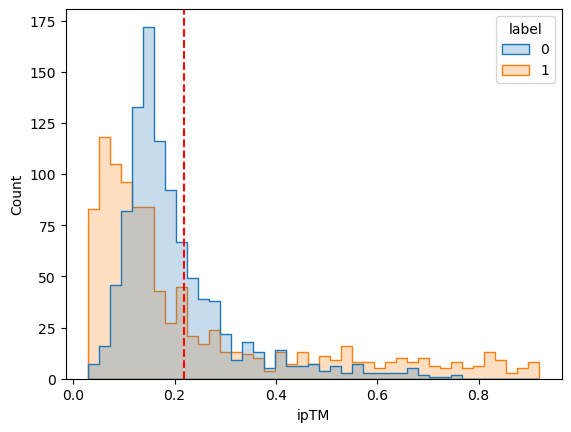

In [11]:
plot_iptm(df_trainval, threshold)

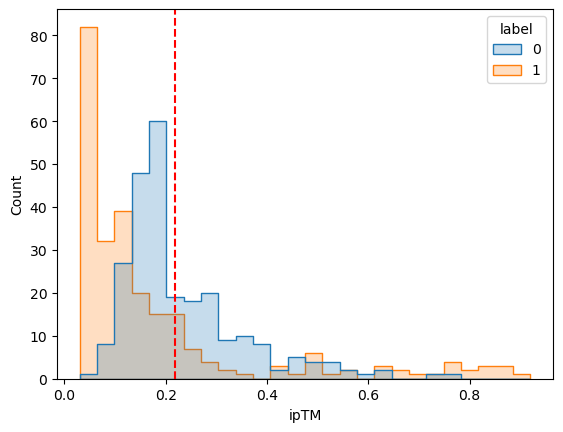

In [12]:
plot_iptm(df_test, threshold)

# Check chain_pair_PAE_min

In [13]:
from sklearn.linear_model import LogisticRegression

X_train = df_trainval[["pae01","pae10"]]
y_train = df_trainval["label"]

model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

In [14]:
with open("results/cpm_model.pkl", "wb") as file:
    pickle.dump(model, file)

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
X_test = df_test[["pae01","pae10"]]
y_test = df_test["label"]

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob[:, 1])}")
print(f"PR AUC: {average_precision_score(y_test, y_prob[:, 1])}")

Accuracy: 0.346
ROC AUC: 0.303936
PR AUC: 0.44216176963720233


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cpm(df, model):
    sns.scatterplot(data=df, x='pae01', y='pae10', hue='label')

    # Draw logistic regression
    x_min, x_max = df["pae01"].min() - 1, df["pae01"].max() + 1
    y_min, y_max = df["pae10"].min() - 1, df["pae10"].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Predict probabilities over the grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    # Plot the logistic regression
    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "orange"])
    
    plt.title("Chain Pair PAE min by class")
    plt.show()

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


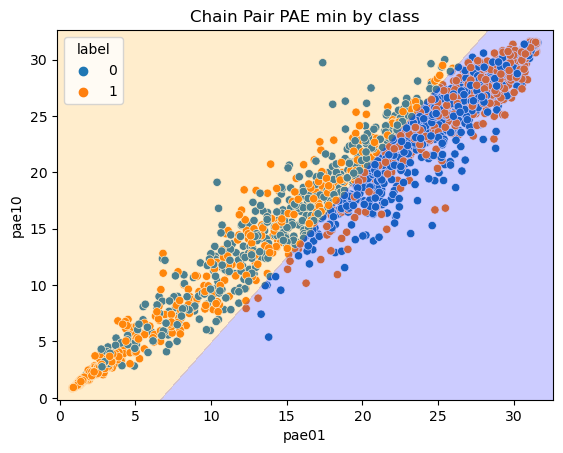

In [17]:
plot_cpm(df_trainval, model)

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


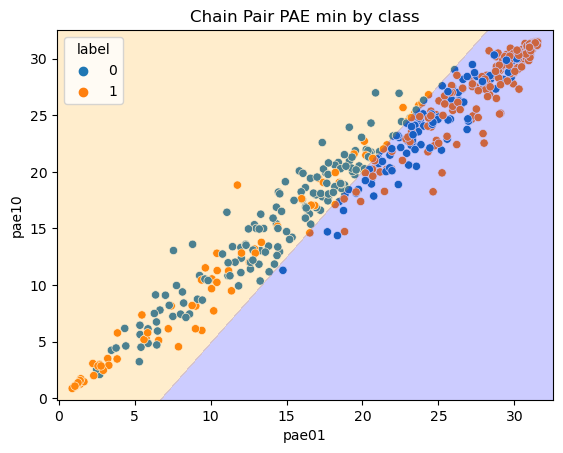

In [18]:
plot_cpm(df_test, model)

# Both ipTM and chain_pair_PAE_min

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

X_train = df_trainval[["ipTM", "pae01", "pae10"]]
y_train = df_trainval["label"]

model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
X_test = df_test[["ipTM", "pae01","pae10"]]
y_test = df_test["label"]

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob[:, 1])}")
print(f"PR AUC: {average_precision_score(y_test, y_prob[:, 1])}")

Accuracy: 0.37
ROC AUC: 0.300816
PR AUC: 0.4507448789833411
